In [22]:
import os
import cv2
import numpy as np
import tensorflow  as tf
from  tensorflow import keras
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import json


In [23]:
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
cloth_dir="test/cloth/"
mask_dir="test/cloth-mask/"
image_dir="test/image/"
openpose_json_dir="test/openpose_json"

In [25]:
cloth_paths = [os.path.join(cloth_dir, file) for file in os.listdir(cloth_dir)]
mask_paths = [os.path.join(mask_dir, file) for file in os.listdir(mask_dir)]
image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir)]
json_paths = [os.path.join(openpose_json_dir, file) for file in os.listdir(openpose_json_dir)]

In [26]:
cloth_paths.sort()
mask_paths.sort()
image_paths.sort()
json_paths.sort()

In [27]:
display(image_paths[:10] , mask_paths[:10])

['test/image/00006_00.jpg',
 'test/image/00008_00.jpg',
 'test/image/00013_00.jpg',
 'test/image/00017_00.jpg',
 'test/image/00034_00.jpg',
 'test/image/00035_00.jpg',
 'test/image/00055_00.jpg',
 'test/image/00057_00.jpg',
 'test/image/00064_00.jpg',
 'test/image/00067_00.jpg']

['test/cloth-mask/00006_00.jpg',
 'test/cloth-mask/00008_00.jpg',
 'test/cloth-mask/00013_00.jpg',
 'test/cloth-mask/00017_00.jpg',
 'test/cloth-mask/00034_00.jpg',
 'test/cloth-mask/00035_00.jpg',
 'test/cloth-mask/00055_00.jpg',
 'test/cloth-mask/00057_00.jpg',
 'test/cloth-mask/00064_00.jpg',
 'test/cloth-mask/00067_00.jpg']

In [30]:
def preprocessing(image_path,mask_path):
    images = []
    masks = []
    for image_path, mask_path in zip(image_path,mask_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (512, 512))
        
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, (512, 512))
    
        images.append(image.numpy()/255.0)
        masks.append(mask.numpy()/255.0)
    images = np.array(images)
    masks = np.array(masks)

    print(images.shape, masks.shape)
    return images,masks

In [31]:
train_images, train_masks = preprocessing(cloth_paths[:150],mask_paths[:150])

(150, 512, 512, 3) (150, 512, 512, 1)


In [32]:
test_images, test_masks = preprocessing(cloth_paths[201:351],mask_paths[201:251])

(50, 512, 512, 3) (50, 512, 512, 1)


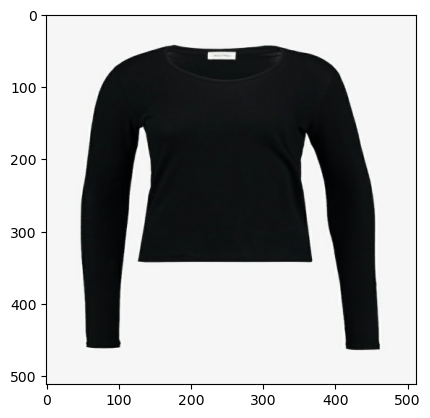

In [33]:
plt.imshow(train_images[0])

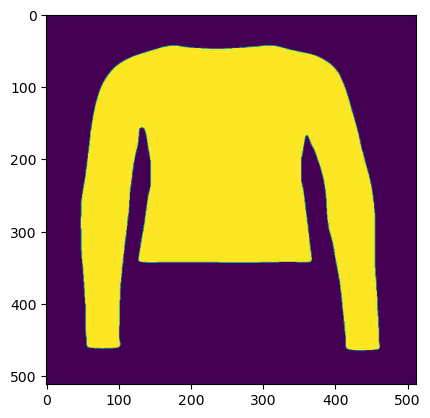

In [34]:
plt.imshow(train_masks[0])

In [35]:
len(train_masks.shape[:-1])

3

# Cloth Mask Generation

In [36]:
def clothing_parser(input_shape=(512, 512, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder
    x = keras.layers.Conv2D(64, (2, 2), strides=2, padding='same', activation='relu')(inputs)
    x = keras.layers.Conv2D(128, (2, 2), strides=2, padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(256, (2, 2), strides=2, padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (2, 2), strides=2, padding='same', activation='relu')(x)
    
    # Decoder
    x = keras.layers.Conv2DTranspose(256, (2, 2), strides=2, padding='same', activation='relu')(x)
    x = keras.layers.Conv2DTranspose(128, (2,2), strides=2, padding='same', activation='relu')(x)
    x = keras.layers.Conv2DTranspose(32, (2, 2), strides=2, padding='same', activation='sigmoid')(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Conv2DTranspose(1, (2, 2), strides=2, padding='same', activation='sigmoid')(x)
    
    return keras.models.Model(inputs, outputs, name='ClothingParser')
model=clothing_parser(input_shape=(512,512,3))
model.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['accuracy'])

In [37]:
model=clothing_parser(input_shape=(512,512,3))

In [38]:
model.summary()

Model: "ClothingParser"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 64)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 128)       │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 512)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 128, 128, 128)       │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 256, 256, 32)        │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 512, 512, 1)         │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,363,297 (5.20 MB)

 Trainable params: 1,362,721 (5.20 MB)

 Non-trainable params: 576 (2.25 KB)

In [39]:
model.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['accuracy'])

In [40]:
model.fit(train_images, train_masks,batch_size=2,epochs=10)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 643ms/step - accuracy: 0.8188 - loss: 0.3895
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 634ms/step - accuracy: 0.8902 - loss: 0.2429
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 636ms/step - accuracy: 0.9052 - loss: 0.2109
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 631ms/step - accuracy: 0.9347 - loss: 0.1269
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 643ms/step - accuracy: 0.9379 - loss: 0.1183
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 639ms/step - accuracy: 0.9251 - loss: 0.1421
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 644ms/step - accuracy: 0.9314 - loss: 0.1414
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 648ms/step - accuracy: 0.9104 - loss: 0.1848
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 636ms/step - accuracy: 0.9286 - loss: 0.1534
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 641ms/step - accuracy: 0.9214 - loss: 0.1687


In [41]:
loss,accuracy = model.evaluate(test_images,test_masks)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 723ms/step - accuracy: 0.9332 - loss: 0.1676


In [42]:
print(f"Test Loss:{loss:.5f}, Test Accuracy:{accuracy:.5f}")

Test Loss:0.16271, Test Accuracy:0.93270


In [43]:
model.save('MaskGenerationModel.keras')

In [44]:
history=model.predict(test_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 860ms/step


In [45]:
history

array([[[[0.02420922],
         [0.02742933],
         [0.02936572],
         ...,
         [0.0562049 ],
         [0.06810935],
         [0.06683264]],

        [[0.02382605],
         [0.02524965],
         [0.02682969],
         ...,
         [0.05424535],
         [0.06548373],
         [0.06861249]],

        [[0.02126508],
         [0.02053759],
         [0.02945486],
         ...,
         [0.05067432],
         [0.05794322],
         [0.07557935]],

        ...,

        [[0.05370704],
         [0.0564646 ],
         [0.0740808 ],
         ...,
         [0.1507395 ],
         [0.16954924],
         [0.18969578]],

        [[0.04655741],
         [0.05144435],
         [0.07189252],
         ...,
         [0.13614453],
         [0.1948407 ],
         [0.23014154]],

        [[0.04617303],
         [0.0522847 ],
         [0.07540058],
         ...,
         [0.15271167],
         [0.19152346],
         [0.22410284]]],


       [[[0.02420922],
         [0.02742933],
         [0.02

Model Results


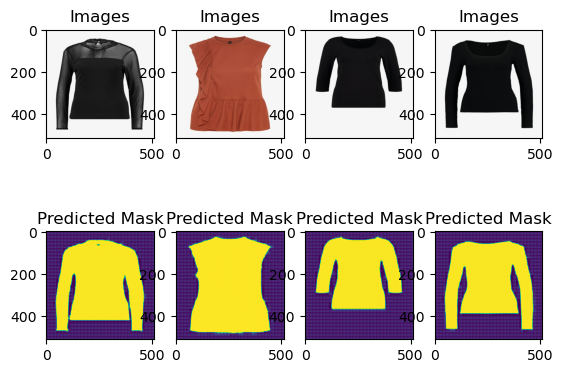

In [47]:
print("Model Results")
for i  in  range(4):
    plt.subplot(2,4,i+1)
    plt.title("Images")
    plt.imshow(test_images[i+5])
    plt.subplot(2,4,i+5)
    plt.title("Predicted Mask")
    plt.imshow(history[i+5])